### Brian Naughton
### ST 790 - HW 7

In [1]:
versioninfo()

Julia Version 0.3.7
Commit cb9bcae* (2015-03-23 21:36 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-2670QM CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblas
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


#### Q1 Implement lasso penalized linear regression using three methods:  
#####(1a) convex optimization solver  

In [2]:
# Fit Lasso using Convex Optimization solver 
using Convex, Mosek
solver = MosekSolver(LOG=0)
set_default_solver(solver)

function lasso_convex(X, y, λ)
  β = Variable(size(X, 2))
  problem = minimize(0.5 * norm(y- X*β, 2)^2 + λ * norm(β[2:end], 1))
  solve!(problem)
  return β.value
end;

#####(1b) coordinate descent (CD) 

In [3]:
# soft-thresholding function
function softThresh(z, γ)
  sign(z) * max(abs(z) - γ, 0)
end

function lasso_cd(X, y, λ, tol, β = (y \ X)')
  currObj = .001
  prevObj = .001
  x1 = X[1, 1] # Assumes X[:,1] = x1
  p = size(X, 2)
  XjpXj = zeros(p)
  for j = 1:p # faster than diag(X'X)
    XjpXj[j] = norm(X[:,j])^2
  end
  n = size(X, 1)
  r = vec(y - X * β)
  iters = 0
  while abs(currObj - prevObj)/prevObj  > tol || iters == 0
    prevObj = copy(currObj)
    # Update β_0:
      βnew = β[1] + mean(r) / x1
      r = r .+ ((β[1] - βnew)*x1)
      β[1] = βnew
    # Update β_j's
      for j = 2:p
        z = β[j] + dot(X[:,j], r) / XjpXj[j]
        βnew = softThresh(z, λ / XjpXj[j])
        r += (β[j] - βnew) .* X[:, j]
        β[j] = βnew
      end
    currObj = .5 * norm(y-X*β)^2 + λ * norm(β[2:end], 1)
    iters += 1
  end
  return β
end

lasso_cd (generic function with 2 methods)

 
#####(1c) accelerated proximal gradient method (FISTA)

In [4]:
function lasso_apg(X, y, λ, tol, β = (y \ X)')
  currObj = .001
  prevObj = .001
  p = size(X, 2)
  n = size(X, 1)
  x1 = X[1, 1] # Assumes X[:,1] = x1
  s = 1 / eigmax(X' * X)
  βtm1 = copy(β)
  βtm2 = copy(β)
  r = vec(y - X * β)
  iters = 0
  while abs(currObj - prevObj)/prevObj  > tol || iters == 0
    iters += 1
    prevObj = copy(currObj)
    # Update β_0:
      βnew = β[1] + mean(r) / x1
      r = r .+ ((β[1] - βnew)*x1)
      β[1] = βnew
    # Update β_j's
      Xpr = X' * r
      βextr = βtm1 + (iters-2)/(iters+1) .* (βtm1 - βtm2)
      z = βextr + s .* Xpr
      for j = 2:p
        βnew = softThresh(z[j], λ * s)
        r += (β[j] - βnew) .* X[:, j]
        β[j] = βnew
      end
    βtm1 = deepcopy(β)
    βtm2 = deepcopy(βtm1)
    currObj = .5 * norm(y-X*β)^2 + λ * norm(β[2:end], 1)
  end
  return β
end

lasso_apg (generic function with 2 methods)

#### Q2 Create design matrix and responses for $ n = 10,000 $ and $ p = 1,000 $

In [5]:
function formH(n, p = n)
  # Default is to return n*n matrix, otherwise n*p portion of H
  H = zeros(n, n)
  H[:, 1] = 1 / sqrt(n)
  for j = 2:n
    for i = 1:(j-1)
      H[i, j] = 1/sqrt(j * (j-1))
    end
    H[j, j] = -(j-1)/sqrt(j * (j-1))
  end
  return H[:, 1:p]
end

p = 1000
n = 10000
X = formH(n, p)
βtrue = zeros(p)
βtrue[1:5] = 1:5
srand(2015790003)
y = X * βtrue + randn(n);

#### Q3 Derive an analytical solution to the LASSO problem for the specific form in Q2.
Note that $ X'X = I $ for this form of X.  
$ \widehat \beta_{lasso} = arg~min_{\beta} \frac{1}{2} y'y - y'X\beta + \frac{1}{2} \beta 'X'X\beta + \lambda \sum_{j=2}^p |\beta_j| $  
$ \; =  arg~min_{\beta} - y'X\beta + \frac{1}{2} \beta'\beta + \lambda \sum_{j=2}^p |\beta_j| $  

which is linearly separable in $ \beta $.  

$ \frac{\partial}{\partial \beta_1} (\cdots) = - \sum_{i=1}^n \frac{y_i}{\sqrt{n}} + \beta_1 \equiv 0 $  
$ \; \Rightarrow \widehat \beta_1 = \frac{\sum y_i}{\sqrt{n}} $.  

$ \frac{\partial}{\partial \beta_j} (\cdots) = - \frac{\sum_{i=1}^{j-1} y_i - y_j}{\sqrt{j*(j-1)}} + \beta_j + \lambda ~ sgn(\beta_j) \equiv 0 $  
$ \; \Rightarrow \widehat \beta_j = sgn \left( \frac{\sum_{i=1}^{j-1} y_i - y_j}{\sqrt{j*(j-1)}} \right) \left(|\frac{\sum_{i=1}^{j-1} y_i - y_j}{\sqrt{j*(j-1)}}| - \lambda \right)_+ = ST\left(\frac{\sum_{i=1}^{j-1} y_i - y_j}{\sqrt{j*(j-1)}}, \lambda \right) $,  
where $ST$ is the soft-thresholding operator.

In [6]:
# This function calculates the analytical solution for a given λ
function getAnalyticalSoln(y, p, λ)
  n = size(y,1)
  β = zeros(p)
  for j = 2:p
    ystar = sum(y[1:(j-1)]) - y[j]
    ystar /= sqrt(j*(j-1))
    β[j] = softThresh(ystar, λ)
  end
  β[1] = sum(y) / sqrt(n)
  return β
end;

#### Q4 Test algorithms:
#### Q4 (a)  - Plot solution paths for each algorithm and analytical solutions

In [7]:
λs = 0:0.6:6
N = length(λs)

βs_convex = zeros(p, N)
βs_cd = zeros(p, N)
βs_apg = zeros(p, N)
βs_Solutions = zeros(p, N)
for i in 1:N
  βs_Solutions[:, i] = getAnalyticalSoln(y, p, λs[i])
end

for i in 1:N
  βs_convex[:,i] = lasso_convex(X, y, λs[i])
  βs_cd[:,i] = lasso_cd(X, y, λs[i], 10e-4)
  βs_apg[:,i] = lasso_apg(X, y, λs[i], 10e-4)
end

using Gadfly, DataFrames
function PlotSolutionPath(λs, βs, title="")
  p = size(βs, 1)
  N = length(λs)
  solutionpath = DataFrame(Predictor = rep(2:p, N),
    Coef = reshape(βs[2:end, :], ((p-1) * N)),
    λ = rep(λs, each=(p-1)))
  plot(solutionpath, layer(x=:λ, y=:Coef, color=:Predictor, Geom.line),
    Guide.xlabel("λ"), Guide.ylabel("βhat(λ)"), Guide.title(title))
end

PlotSolutionPath (generic function with 2 methods)

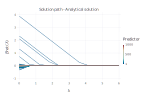

In [8]:
PlotSolutionPath(λs, βs_Solutions, "Solution path - Analytical solution")

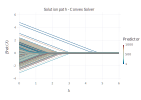

In [9]:
PlotSolutionPath(λs, βs_convex, "Solution path - Convex Solver")

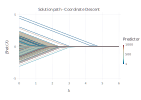

In [10]:
PlotSolutionPath(λs, βs_cd, "Solution path - Coordinate Descent")

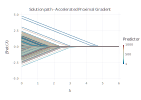

In [11]:
PlotSolutionPath(λs, βs_apg, "Solution path - Accelerated Proximal Gradient")

#### Q4 (b) Report worst error along solution path for each algorithm

In [16]:
errors_convex = zeros(N)
errors_cd = zeros(N)
errors_apg = zeros(N)

for i = 1:11
  errors_convex[i] = norm(βs_convex[:, i] - βs_Solutions[:, i])
  errors_cd[i] = norm(βs_cd[:, i] - βs_Solutions[:, i])
  errors_apg[i] = norm(βs_apg[:, i] - βs_Solutions[:, i])
end

Convex solver - Worst error:

In [17]:
maximum(errors_convex)

30.866177612197397

Coordinate descent - Worst error:

In [14]:
maximum(errors_cd)

30.86615276383864

Accelerated proximal gradient - Worst error:

In [15]:
maximum(errors_apg)

30.86615276383864

#### Q4 (c) - Report run times on server
For timing each algorithm on the teaching server, the julia script, `st790hw7_RunOnServer.jl` executes each version on the server, and the output was saved to a text file displayed below. This command to create this output is: ` julia st790hw7_RunOnServer.jl > outputFromServer.txt`

In [18]:
print(readall(open("outputFromServer.txt")))

versioninfo() 
Julia Version 0.3.7
Platform Info:
  System: Linux (x86_64-redhat-linux)
  CPU: Intel(R) Xeon(R) CPU E5-2640 0 @ 2.50GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblasp.so.0
  LIBM: libopenlibm
  LLVM: libLLVM-3.4.2

Convex solver: 
elapsed time: 120.735935855 seconds (3117622796 bytes allocated, 8.84% gc time)

Coordinate descent: 
elapsed time: 39.010927325 seconds (8012391132 bytes allocated, 73.54% gc time)

Accelerated proximal gradient: 
elapsed time: 133.844928148 seconds (5556349904 bytes allocated, 13.14% gc time)
